<a href="https://colab.research.google.com/github/naufalasr/flight-delay-prediction-cnn/blob/main/Model_DC_CNN_v5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend
import tensorflow as tf
import os


Using TensorFlow backend.


In [ ]:
# for google colab
# !pip install pandas==0.24.1
# !pip install numpy==1.15

In [ ]:
# read file from directory
def read_data(train_dir, val_dir, test_dir):
    train_data = pd.read_pickle(train_dir)
    val_data = pd.read_pickle(val_dir)
    test_data = pd.read_pickle(test_dir)
    return (train_data, val_data, test_data)

In [ ]:
# normalize data using standardization
def normalize(train_data, val_data, test_data):
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)
    
    train_data = train_data - mean
    train_data = train_data / std
    
    val_data = val_data - mean
    val_data = val_data / std
    
    test_data = test_data - mean
    test_data = test_data / std
    
    return train_data, val_data, test_data

In [ ]:
# define prediction target 
def define_target(train_data, val_data, test_data, target_names):
    train_target = train_data[target_names].values
    val_target = val_data[target_names].values
    test_target = test_data[target_names].values
    return (train_target, val_target, test_target)

In [ ]:
# ignore calculating error in first 128 steps
def loss_mae(y_true, y_pred):
    step = 128
    y_true_slice = y_true[:, step:, :]
    y_pred_slice = y_pred[:, step:, :]
    loss = tf.losses.absolute_difference(labels=y_true_slice, predictions=y_pred_slice)
    loss_mae = tf.reduce_mean(loss)
    return loss_mae

In [ ]:
# define model dilated causal convolutional neural network
def define_model(num_x_signals, k_size):
    model = Sequential([
    Conv1D(filters=32, input_shape=( None, num_x_signals ), kernel_size=k_size, padding='causal', dilation_rate=1, activation='relu'),
    Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=2, activation='relu'),
    Dropout(0.2),    
    Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=4, activation='relu'),
    Dropout(0.2),    
    Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=8, activation='relu'),
    #Dropout(0.2),    
#     Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=16, activation='relu'),
#     Dropout(0.2),    
#     Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=32, activation='relu'),
#     Dropout(0.2),
#     Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=64, activation='relu'),
#     Dropout(0.2),
#     Conv1D(filters=32, kernel_size=k_size, padding='causal', dilation_rate=128, activation='relu'),
    Dense(32, activation="relu"), 
    Dense(1)])
    model.compile(Adam(lr=1e-3), loss=loss_mae)
    return model

In [ ]:
# save prediction and plot prediction result
def save_and_plot(start_idx, length=200, train=True):
    # warmup steps
    step=128

    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test_scaled
    
    # inverse y_true to get it back to the original scale
    mean_temp = train_data.mean(axis=0)
    std_temp = train_data.std(axis=0)
    y_true = y_true * std_temp[10] + mean_temp[10]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and of the given length.   
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output
    y_pred = model.predict(x)

    # inverse prediction result to get it back to the original scale 
    # 3 = for DepDelay
    y_pred_rescaled = y_pred[0] * std_temp[10] + mean_temp[10]
   
    # calculate mean absolute error based on prediction result and ignore the first 128 steps
    mae = mean_absolute_error(y_true[step: ], y_pred_rescaled[step: ])
    print("Mean absolute error", mae)

    #save to csv, to google drive 
    !ls "/content/gdrive/My Drive/hasil"
    f = open("/content/gdrive/My Drive/hasil/Hasil B12.csv", "w")
    f.write("{},{}\n".format("True", "Prediction"))
    for x in zip(y_true.flatten(), y_pred_rescaled.flatten()):
      f.write("{},{}\n".format(x[0], x[1]))
    f.close()
    
    #save to csv, to local
#     f = open("D:/Demo/hasil/A1.csv", "w")
#     f.write("{},{}\n".format("True", "Prediction"))
#     for x in zip(y_true.flatten(), y_pred_rescaled.flatten()):
#       f.write("{},{}\n".format(x[0], x[1]))
#     f.close()
    
    # plot for each output-signal.
    for signal in range(len(target_pred)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]

        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(20,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, step, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_pred[signal])
        plt.legend()
        plt.show()

In [ ]:
####### for local directory ###########
# train_dir = "D:/Program TA/data/train/JW3_IND2008_train"
# val_dir = "D:/Program TA/data/val/JW3_IND2008_val"
# test_dir = "D:/Program TA/data/test/JW3_IND2008_test"

########## for google colaboratory, get file from google drive ##########

from google.colab import drive
drive.mount("/content/gdrive")
train_dir = "/content/gdrive/My Drive/data/train/JW3_SAN2008_train"
val_dir = "/content/gdrive/My Drive/data/val/JW3_SAN2008_val"
test_dir = "/content/gdrive/My Drive/data/test/JW3_SAN2008_test"

train_data,val_data, test_data = read_data(train_dir, val_dir, test_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_data['Holiday'] = train_data['Holiday'] * 0.7

In [ ]:
train_data['Holiday']

Datetime
2008-01-01 06:55:00    0.7
2008-01-01 07:15:00    0.7
2008-01-01 07:20:00    0.7
2008-01-01 08:05:00    0.7
2008-01-01 08:10:00    0.7
                      ... 
2008-08-05 15:50:00    0.0
2008-08-05 15:55:00    0.0
2008-08-05 15:55:00    0.0
2008-08-05 16:05:00    0.0
2008-08-05 16:05:00    0.0
Name: Holiday, Length: 21803, dtype: float64

In [ ]:
train_scaled, val_scaled, test_scaled = normalize(train_data, val_data, test_data)

In [ ]:
train_data

,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,LateAircraftDelay,Holiday,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,Target Prediction Delay
Datetime,,,,,,,,,,,
2008-01-01 06:55:00,1,2,655,13,0.0,1,45,49,9.00,0,54
2008-01-01 07:15:00,1,2,715,1,0.0,1,45,49,9.00,0,1
2008-01-01 07:20:00,1,2,720,-6,0.0,1,45,49,9.00,0,23
2008-01-01 08:05:00,1,2,805,-5,0.0,1,47,42,10.00,0,4
2008-01-01 08:10:00,1,2,810,12,0.0,1,47,42,10.00,0,20
2008-01-01 08:15:00,1,2,815,7,0.0,1,47,42,10.00,0,-3
2008-01-01 08:20:00,1,2,820,-1,0.0,1,47,42,10.00,0,-1
2008-01-01 08:35:00,1,2,835,-2,0.0,1,47,42,10.00,0,-1
2008-01-01 09:10:00,1,2,910,-4,0.0,1,51,38,10.00,5,-1


In [ ]:
test_scaled

,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,LateAircraftDelay,Holiday,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,Target Prediction Delay
Datetime,,,,,,,,,,,
2008-09-29 06:30:00,1.518743,-1.462493,-1.609462,-0.439705,-0.325671,-0.178052,0.411181,0.647385,0.610987,-1.762010,-0.478453
2008-09-29 06:35:00,1.518743,-1.462493,-1.598335,-0.315349,-0.325671,-0.178052,0.411181,0.647385,0.610987,-1.762010,-0.561961
2008-09-29 06:40:00,1.518743,-1.462493,-1.587208,-0.439705,-0.325671,-0.178052,0.411181,0.647385,0.610987,-1.762010,-0.436699
2008-09-29 06:40:00,1.518743,-1.462493,-1.587208,-0.398253,-0.325671,-0.178052,0.411181,0.647385,0.610987,-1.762010,-0.436699
2008-09-29 06:45:00,1.518743,-1.462493,-1.576081,-0.522609,-0.325671,-0.178052,0.411181,0.647385,0.610987,-1.762010,-0.645469
2008-09-29 07:00:00,1.518743,-1.462493,-1.453683,-0.481157,-0.325671,-0.178052,0.542561,0.647385,0.610987,-1.762010,-0.603715
2008-09-29 07:05:00,1.518743,-1.462493,-1.442555,-0.564061,-0.325671,-0.178052,0.542561,0.647385,0.610987,-1.762010,-0.520207
2008-09-29 07:15:00,1.518743,-1.462493,-1.420301,-0.605514,-0.325671,-0.178052,0.542561,0.647385,0.610987,-1.762010,-0.561961
2008-09-29 07:25:00,1.518743,-1.462493,-1.398047,-0.273897,-0.325671,-0.178052,0.542561,0.647385,0.610987,-1.762010,-0.394945


In [ ]:
# check if scale back to original
# mean_temp = train_data.mean(axis=0)
# std_temp = train_data.std(axis=0)
# test_scaled["Target Prediction Delay"] * std_temp[10] + mean_temp[10]

In [ ]:
# define prediction target both train and test
target_pred = ['Target Prediction Delay']
y_train_scaled, y_val_scaled, y_test_scaled = define_target(train_scaled,
                                                            val_scaled,
                                                            test_scaled,
                                                            target_pred)

In [ ]:
x_train_scaled

array([[-1.63039157, -0.96195569, -1.55382649, ..., -0.83274381,
         0.03069333, -1.76200967],
       [-1.63039157, -0.96195569, -1.4203012 , ..., -0.83274381,
         0.03069333, -1.76200967],
       [-1.63039157, -0.96195569, -1.4091741 , ..., -0.83274381,
         0.03069333, -1.76200967],
       ...,
       [-1.18051525, -0.96195569,  0.44905273, ..., -0.03100716,
         0.6109873 ,  0.57550763],
       [-1.18051525, -0.96195569,  0.5603238 , ..., -0.03100716,
         0.57616966,  0.57550763],
       [-1.18051525, -0.96195569,  0.5603238 , ..., -0.03100716,
         0.57616966,  0.57550763]])

In [ ]:
#drop target 
x_train_scaled = train_scaled.drop(['Target Prediction Delay','DepDelay'], axis=1).values
x_val_scaled = val_scaled.drop(['Target Prediction Delay','DepDelay'], axis=1).values
x_test_scaled = test_scaled.drop(['Target Prediction Delay','DepDelay'], axis=1).values

In [ ]:
y_train_scaled

array([[ 1.81801909],
       [-0.39494452],
       [ 0.52364415],
       ...,
       [-0.47845259],
       [ 0.23136593],
       [ 0.23136593]])

In [ ]:
# check if scale back to original
# mean_temp = train_data.mean(axis=0)
# std_temp = train_data.std(axis=0)
# y_train_scaled["Target Prediction Delay"] * std_temp[10] + mean_temp[10]

In [ ]:
batch_size = 256 

In [ ]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

In [ ]:
x_train_scaled.shape

(21803, 9)

In [ ]:
num_input = x_train_scaled.shape[1]
kernel_size = 2
model = define_model(num_input,kernel_size)
model.summary()

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_773 (Conv1D)          (None, None, 32)          608       
_________________________________________________________________
conv1d_774 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
dropout_255 (Dropout)        (None, None, 32)          0         
_________________________________________________________________
conv1d_775 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
dropout_256 (Dropout)        (None, None, 32)          0         
_________________________________________________________________
conv1d_776 (Conv1D)          (None, None, 32)          2080      
_________________________________________________________________
dense_270 (Dense)            (None, None, 32)       

In [ ]:
# for early stopping 
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, 
                                        verbose=1)

callbacks = [callback_early_stopping]

In [ ]:
epoch = 50
steps_per_epoch = math.ceil(len(train_data)/batch_size)
# epoch = 1
# steps_per_epoch = 1

In [ ]:
%%time
history = model.fit(x=np.expand_dims(x_train_scaled, axis=0), 
                    y=np.expand_dims(y_train_scaled, axis=0), 
                    epochs=epoch,
                    batch_size = batch_size,
                    steps_per_epoch=steps_per_epoch, 
                    validation_data = validation_data, 
                    callbacks = callbacks)

Epoch 1/50
86/86 [==============================] - 34s 390ms/step - loss: 0.5084 - val_loss: 0.3399
Epoch 2/50
86/86 [==============================] - 2s 19ms/step - loss: 0.4884 - val_loss: 0.3379
Epoch 3/50
86/86 [==============================] - 2s 19ms/step - loss: 0.4742 - val_loss: 0.3333
Epoch 4/50
86/86 [==============================] - 2s 19ms/step - loss: 0.4599 - val_loss: 0.3359
Epoch 5/50
86/86 [==============================] - 2s 19ms/step - loss: 0.4505 - val_loss: 0.3389
Epoch 6/50
86/86 [==============================] - 2s 20ms/step - loss: 0.4435 - val_loss: 0.3410
Epoch 7/50
86/86 [==============================] - 2s 20ms/step - loss: 0.4384 - val_loss: 0.3411
Epoch 8/50
86/86 [==============================] - 2s 20ms/step - loss: 0.4345 - val_loss: 0.3435
Epoch 00008: early stopping
CPU times: user 43 s, sys: 2.53 s, total: 45.5 s
Wall time: 45.8 s


In [ ]:
# save_and_plot(start_idx=0, length=200000, train=True)

Mean absolute error 14.76004684398626
'Hasil A10.csv'  'Hasil A8.csv'   'Hasil B6.csv'   'Hasil C4.csv'
'Hasil A11.csv'  'Hasil A9.csv'   'Hasil B7.csv'   'Hasil C5.csv'
'Hasil A12.csv'  'Hasil B10.csv'  'Hasil B8.csv'   'Hasil C6.csv'
'Hasil A1.csv'	 'Hasil B11.csv'  'Hasil B9.csv'   'Hasil C7.csv'
'Hasil A2.csv'	 'Hasil B12.csv'  'Hasil C10.csv'  'Hasil C8.csv'
'Hasil A3.csv'	 'Hasil B1.csv'   'Hasil C11.csv'  'Hasil C9.csv'
'Hasil A4.csv'	 'Hasil B2.csv'   'Hasil C12.csv'  'Hasil Z2.csv'
'Hasil A5.csv'	 'Hasil B3.csv'   'Hasil C1.csv'
'Hasil A6.csv'	 'Hasil B4.csv'   'Hasil C2.csv'
'Hasil A7.csv'	 'Hasil B5.csv'   'Hasil C3.csv'


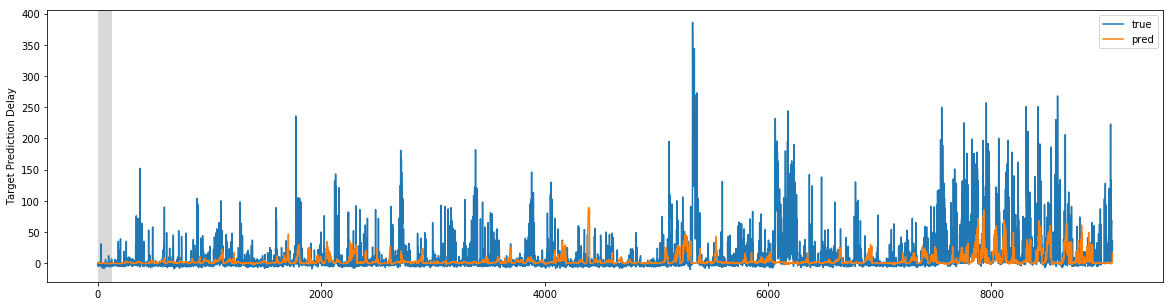

In [ ]:
save_and_plot(start_idx=0, length=20000, train=False)